# Lecture 19 - Transformers 

```{contents}
:local:
:depth: 1
```

## Learning goals

- Define tokens, embeddings, positional encodings, attention, and multi-head attention.
- Visualize **attention** as heatmaps on SMILES examples.
- Implement a mini Transformer Encoder block and train it on a chemistry task from SMILES.

[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1LL15O48eHY08B9gQu14ui3zYushfLyCj?usp=sharing)     

## 1. Setup

In [1]:
# Commented out IPython magic to ensure Python compatibility.
# 0. Setup
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional dependencies for Colab. These will be skipped if no internet.
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
except Exception as e:
    torch = None

try:
    from rdkit import Chem
    from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
except Exception:
    try:
#         %pip install rdkit
        from rdkit import Chem
        from rdkit.Chem import Draw, Descriptors, Crippen, rdMolDescriptors, AllChem
    except Exception as e:
        print("RDKit is not available in this environment. Drawing and descriptors will be skipped.")
        Chem = None

import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(precision=3, suppress=True)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def show_img(mat, title=""):
    plt.figure()
    plt.imshow(mat, aspect="auto")
    plt.title(title)
    plt.xlabel("Key positions")
    plt.ylabel("Query positions")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

def print_shape(name, x):
    try:
        print(f"{name}.shape =", tuple(x.shape))
    except Exception:
        print(f"{name}: type {type(x)}")

---
## 1. From SMILES to tokens

We will treat a SMILES string as a sequence of characters. This is not the only way to tokenize chemistry, but it is simple and enough for a first pass.

- **Token**: a symbol in a sequence. Here we use characters such as `C`, `O`, `(`, `)`, `=`, digits for ring closures, and `[` `]` for special atoms.
- **Embedding**: a vector that represents a token.
- **Sequence length**: number of tokens.

In [2]:
# Build a tiny SMILES vocabulary from a small set of molecules
sample_smiles = [
    "CCO",           # ethanol
    "CC(=O)O",       # acetic acid
    "c1ccccc1",      # benzene
    "CCN",           # ethylamine
    "CCCl",          # chloroethane
    "CC(=O)NC",      # acetamide
    "C=CC=O",        # acrolein
    "C1CCCCC1",      # cyclohexane
]

# Extract characters seen in these SMILES plus a few common brackets
special = list("[]=#@+-")
chars = sorted(set("".join(sample_smiles)) | set(special) | set("()"))
# Add PAD and UNK
itos = ["<PAD>", "<UNK>"] + chars
stoi = {ch:i for i,ch in enumerate(itos)}

print("Vocab size:", len(itos))
print("First 20 tokens:", itos[:20])

def tokenize(smiles, max_len=24):
    ids = []
    for ch in smiles:
        ids.append(stoi.get(ch, stoi["<UNK>"]))
    # pad or trim
    ids = ids[:max_len] + [stoi["<PAD>"]] * max(0, max_len - len(ids))
    return np.array(ids, dtype=np.int64)

def detokenize(ids):
    return "".join([itos[i] if 0 <= i < len(itos) else "?" for i in ids if itos[i] != "<PAD>"])

x = tokenize("CC(=O)O", max_len=16)
print("Token ids for acetic acid:", x[:10], "...")
print("Back to text:", detokenize(x))

Vocab size: 17
First 20 tokens: ['<PAD>', '<UNK>', '#', '(', ')', '+', '-', '1', '=', '@', 'C', 'N', 'O', '[', ']', 'c', 'l']
Token ids for acetic acid: [10 10  3  8 12  4 12  0  0  0] ...
Back to text: CC(=O)O


Now we will load the C-H oxidation dataset with SMILES and properties.

In [3]:
# Load data
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
df_raw = pd.read_csv(url)
print("Columns:", list(df_raw.columns))
df_raw.head(3)

def calc_descriptors(smiles):
    if Chem is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
    })

desc = df_raw["SMILES"].apply(calc_descriptors)
df = pd.concat([df_raw, desc], axis=1)

# Build classification frame
label_map = {"toxic": 1, "non_toxic": 0}
df_clf = df.dropna(subset=["SMILES"]).copy()
df_clf = df_clf[df_clf["Toxicity"].str.lower().isin(label_map.keys())]
df_clf["y"] = df_clf["Toxicity"].str.lower().map(label_map).astype(int)

print("Class balance:\n", df_clf["y"].value_counts())
df_clf.head(3)

Columns: ['Compound Name', 'CAS', 'SMILES', 'Solubility_mol_per_L', 'pKa', 'Toxicity', 'Melting Point', 'Reactivity', 'Oxidation Site']


Class balance:
 y
1    474
0    101
Name: count, dtype: int64


,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings,y
0,"3,4-dihydro-1H-isochromene",493-05-0,c1ccc2c(c1)CCOC2,0.103906,5.80,non_toxic,65.8,1,"8,10",134.178,1.7593,9.23,2.0,0
1,9H-fluorene,86-73-7,c1ccc2c(c1)Cc1ccccc1-2,0.010460,5.82,toxic,90.0,1,7,166.223,3.2578,0.00,3.0,1
2,"1,2,3,4-tetrahydronaphthalene",119-64-2,c1ccc2c(c1)CCCC2,0.020589,5.74,toxic,69.4,1,"7,10",132.206,2.5654,0.00,2.0,1


---
## 2. Embeddings and positional encoding

We map each token id to a vector of size `d_model`. We also add a position-dependent signal so the model can tell the difference between the same token at different positions.

**Embeddings and positions**  
For token id $x_t$ and model size $d$:
$$
E_t = W_{\text{emb}}[x_t] \in \mathbb{R}^{d}
$$
Sinusoidal positional encoding for position $p$ and channels $2i, 2i+1$:
$$
\text{PE}(p,2i) = \sin\!\left(\frac{p}{10000^{2i/d}}\right),\quad
\text{PE}(p,2i+1) = \cos\!\left(\frac{p}{10000^{2i/d}}\right)
$$
Input to attention is $H_t = E_t + \text{PE}_t$.

pe.shape = (16, 32)


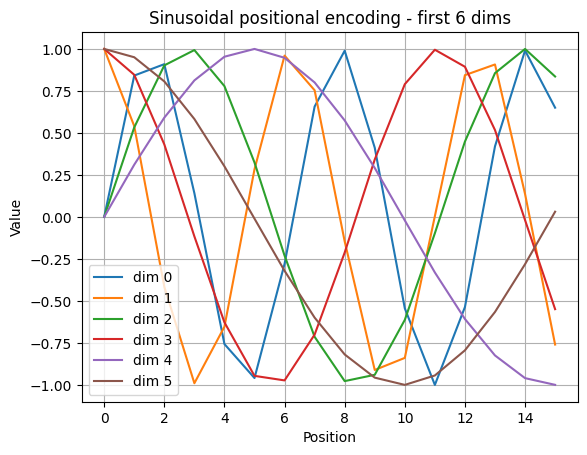

In [4]:
def sinusoidal_positional_encoding(seq_len, d_model):
    pe = np.zeros((seq_len, d_model), dtype=np.float32)
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            denom = 10000 ** (i / d_model)
            pe[pos, i] = math.sin(pos / denom)
            if i + 1 < d_model:
                pe[pos, i + 1] = math.cos(pos / denom)
    return pe

# Example
seq_len = 16
d_model = 32
pe = sinusoidal_positional_encoding(seq_len, d_model)
print_shape("pe", pe)

# Visualize a few dimensions
plt.figure()
for d in [0, 1, 2, 3, 4, 5]:
    plt.plot(pe[:40, d], label=f"dim {d}")
plt.title("Sinusoidal positional encoding - first 6 dims")
plt.xlabel("Position")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

---
## 3. Scaled dot-product attention

Given query `Q`, key `K`, and value `V`, attention is:

$$
\text{Attn}(Q,K,V) = \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

Q.shape = (1, 12, 16)
K.shape = (1, 12, 16)
V.shape = (1, 12, 16)
weights.shape = (1, 12, 12)
out.shape = (1, 12, 16)


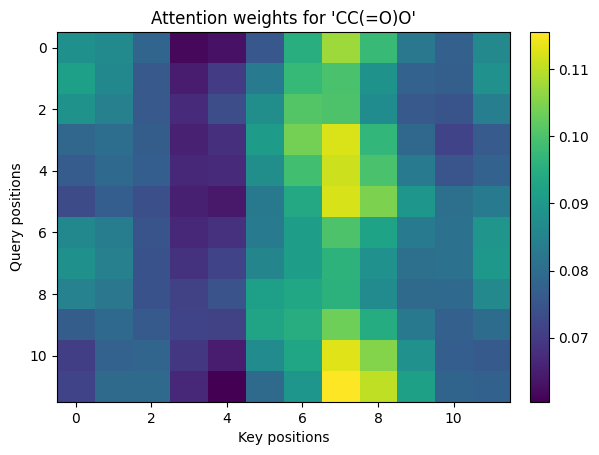

In [5]:
def softmax_np(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)
    e = np.exp(x)
    return e / np.sum(e, axis=axis, keepdims=True)

def scaled_dot_product_attention_np(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    scores = Q @ K.transpose(0,2,1) / math.sqrt(d_k)   # (B, Tq, Tk)
    if mask is not None:
        scores = scores + (mask * -1e9)
    weights = softmax_np(scores, axis=-1)
    out = weights @ V
    return out, weights

# Build toy embeddings by projecting one-hot tokens
def one_hot(vocab_size, ids):
    oh = np.zeros((len(ids), vocab_size), dtype=np.float32)
    for i, idx in enumerate(ids):
        if idx < vocab_size:
            oh[i, idx] = 1.0
    return oh

rng = np.random.default_rng(0)
d_model = 16
max_len = 12

sm = "CC(=O)O"
ids = tokenize(sm, max_len=max_len)
T = len(ids)

E = rng.standard_normal((len(itos), d_model)).astype(np.float32) * 0.1  # embedding table
X = one_hot(len(itos), ids) @ E                                        # (T, d_model)
PE = sinusoidal_positional_encoding(max_len, d_model)
H = X + PE[:T]                                                          # add position

# Linear projections
Wq = rng.standard_normal((d_model, d_model)).astype(np.float32) * 0.2
Wk = rng.standard_normal((d_model, d_model)).astype(np.float32) * 0.2
Wv = rng.standard_normal((d_model, d_model)).astype(np.float32) * 0.2

Q = H @ Wq
K = H @ Wk
V = H @ Wv

# Add batch dimension B=1
Qb = Q[None, ...]
Kb = K[None, ...]
Vb = V[None, ...]

out, weights = scaled_dot_product_attention_np(Qb, Kb, Vb)
print_shape("Q", Qb); print_shape("K", Kb); print_shape("V", Vb)
print_shape("weights", weights); print_shape("out", out)

# Visualize attention weights
show_img(weights[0], title=f"Attention weights for '{sm}'")

---
## 4. Multi-head attention

Multiple heads split the model dimension into smaller subspaces that attend differently. We will build 2 heads for clarity.

`Multi-head attention` with $h$ heads have the following equation:
$$
\text{MHA}(X) = \text{Concat}(\text{head}_1,\dots,\text{head}_h)W^O,\quad
\text{head}_j = \text{Attn}(XW_j^Q, XW_j^K, XW_j^V)
$$

Later, we will build `Residual` and `LayerNorm`:
$$
Y = \text{LayerNorm}(X + \text{SubLayer}(X))
$$

with `Classifier` head:
$$
\hat{y} = \text{softmax}(W_c\, \text{Pool}(H) + b_c)
$$

and `Losses`:
$$
\mathcal{L}_{\text{CE}} = -\frac{1}{N}\sum_{i=1}^N\sum_{c=1}^2 y_{i,c}\log \hat{p}_{i,c}
\qquad
\text{MSE} = \frac{1}{N}\sum_i (y_i - \hat{y}_i)^2
$$

Y (mha output).shape = (12, 16)


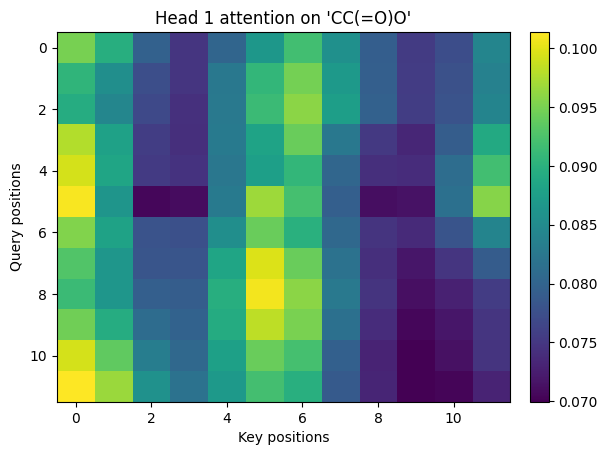

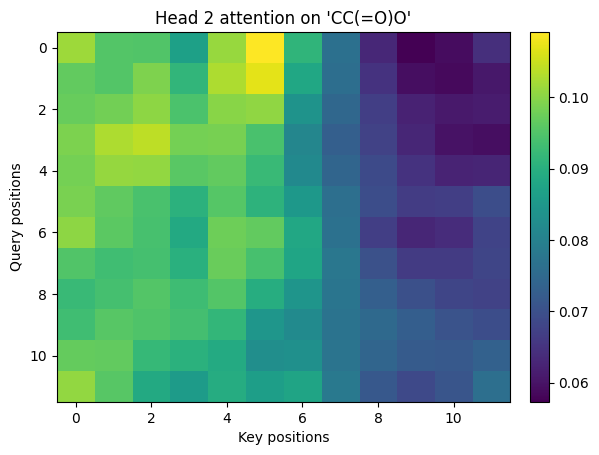

In [6]:
def multi_head_attention_np(H, num_heads=2):
    B = 1
    T, d_model = H.shape
    assert d_model % num_heads == 0
    d_k = d_model // num_heads

    rng = np.random.default_rng(1)
    Wq = rng.standard_normal((num_heads, d_model, d_k)).astype(np.float32) * 0.2
    Wk = rng.standard_normal((num_heads, d_model, d_k)).astype(np.float32) * 0.2
    Wv = rng.standard_normal((num_heads, d_model, d_k)).astype(np.float32) * 0.2
    Wo = rng.standard_normal((num_heads * d_k, d_model)).astype(np.float32) * 0.2

    all_weights = []
    all_heads = []

    for h in range(num_heads):
        Q = H @ Wq[h]
        K = H @ Wk[h]
        V = H @ Wv[h]

        out, w = scaled_dot_product_attention_np(Q[None, ...], K[None, ...], V[None, ...])
        all_weights.append(w[0])
        all_heads.append(out[0])

    H_cat = np.concatenate(all_heads, axis=-1)   # (T, num_heads*d_k)
    Y = H_cat @ Wo                               # (T, d_model)
    return Y, all_weights

Y, head_weights = multi_head_attention_np(H, num_heads=2)
print_shape("Y (mha output)", Y)

# Visualize each head
for i, w in enumerate(head_weights, 1):
    show_img(w, title=f"Head {i} attention on '{sm}'")

---

## 5. Transformer Encoder block for a small chemistry task

Now, we will use what we learn before to do a demo.
We train a small encoder on SMILES to predict `toxic` vs `non_toxic`.

In the section, we will:
1. Split the data with stratification
2. Create a character vocab, tokenizer, and padding policy
3. Build a `Dataset` and `DataLoader` with a custom collate
4. Define a tiny encoder with sinusoidal positional encoding and mean pooling
5. Train with cross entropy and track loss
6. Report accuracy and ROC AUC, draw a confusion matrix and an ROC curve
7. Inspect one attention head on a test sequence

In [7]:
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Split
X_text = df_clf['SMILES'].astype(str).tolist()
y_all  = df_clf['y'].values.astype(np.int64)

X_train_txt, X_test_txt, y_train, y_test = train_test_split(
    X_text, y_all, test_size=0.2, random_state=SEED, stratify=y_all
)

print(f"Train size: {len(X_train_txt)}  Test size: {len(X_test_txt)}")

Train size: 460  Test size: 115


We use a simple character vocab built from the training SMILES. A special pad token fills sequences to a common length.
Let $ S $ be the set of non pad positions for a sequence with hidden states $ h_t \in \mathbb{R}^{d} $.  
Mean pooling over valid tokens:
$$
\bar{h} \;=\; \frac{1}{|S|}\sum_{t \in S} h_t
$$

Sinusoidal positional encoding for position \(p\) and channel index \(2i\) and \(2i+1\):
$$
\mathrm{PE}(p, 2i)   = \sin\!\left(p \,/\, 10000^{\frac{2i}{d}}\right), \quad
\mathrm{PE}(p, 2i+1) = \cos\!\left(p \,/\, 10000^{\frac{2i}{d}}\right).
$$

In [8]:
# Specials and vocab
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
MAX_LEN   = 256  # keep this in sync with the model

# Build vocab from training texts
chars = sorted(set("".join(X_train_txt)))
itos = [PAD_TOKEN, UNK_TOKEN] + chars
stoi = {t: i for i, t in enumerate(itos)}
PAD = stoi[PAD_TOKEN]
UNK = stoi[UNK_TOKEN]

def tokenize(s: str):
    ids = [stoi.get(ch, UNK) for ch in s]
    return ids[:MAX_LEN]

def sinusoidal_positional_encoding(max_len: int, d_model: int):
    pe = np.zeros((max_len, d_model), dtype=np.float32)
    position = np.arange(max_len)[:, None]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return pe

# Dataset and collate
class SmilesSet(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        ids = tokenize(self.texts[idx])
        return np.array(ids, dtype=np.int64), int(self.labels[idx])

def collate(batch):
    xs, ys = zip(*batch)
    max_len = max(len(x) for x in xs)
    pad_x = [np.pad(x, (0, max_len - len(x)), constant_values=PAD) for x in xs]
    return torch.from_numpy(np.stack(pad_x)).long(), torch.tensor(ys).long()

train_ds = SmilesSet(X_train_txt, y_train)
test_ds  = SmilesSet(X_test_txt,  y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  collate_fn=collate)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, collate_fn=collate)

print(f"Vocab size: {len(itos)} tokens")

Vocab size: 36 tokens


Now, we use a tiny Transformer encoder with multi head self attention and a feed forward block, then mean pooling and a classifier head.

Binary cross entropy over softmax probabilities reduces to the usual cross entropy on two classes:
$$
L \;=\; -\frac{1}{N}\sum_{i=1}^{N} \sum_{c \in \{0,1\}} y_{ic}\,\log p_{ic}.
$$

In [9]:
# Tiny transformer encoder
class TinyEncoder(nn.Module):
    def __init__(self, vocab, d_model=64, heads=2, ff=128, max_len=256):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model, padding_idx=PAD)
        pe = sinusoidal_positional_encoding(max_len, d_model).astype(np.float32)
        self.register_buffer("pe", torch.from_numpy(pe))
        self.mha = nn.MultiheadAttention(d_model, heads, batch_first=True)
        self.ln1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, ff),
            nn.ReLU(),
            nn.Linear(ff, d_model),
        )
        self.ln2 = nn.LayerNorm(d_model)
        self.cls = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 2)
        )
    def forward(self, x):
        B, T = x.shape
        h = self.emb(x) + self.pe[:T].unsqueeze(0)
        key_padding = (x == PAD)  # True positions are ignored
        h2, attn = self.mha(h, h, h, key_padding_mask=key_padding, need_weights=True, average_attn_weights=False)
        h = self.ln1(h + h2)
        h2 = self.ff(h)
        h = self.ln2(h + h2)
        # mean pool over valid tokens
        denom = (~key_padding).sum(dim=1, keepdim=True).clamp(min=1)
        pooled = (h.masked_fill(key_padding.unsqueeze(-1), 0).sum(dim=1) / denom)
        logits = self.cls(pooled)
        return logits, attn, key_padding

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyEncoder(len(itos), d_model=64, heads=2, ff=128, max_len=MAX_LEN).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)

def run_epoch(loader, train=True):
    if train: model.train()
    else: model.eval()
    total, correct, losses = 0, 0, []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits, _, _ = model(xb)
        loss = F.cross_entropy(logits, yb)
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
        losses.append(loss.item())
    return np.mean(losses), correct / max(total, 1)

epoch 05  train_loss=0.2077  train_acc=0.900  test_acc=0.896


epoch 10  train_loss=0.1285  train_acc=0.930  test_acc=0.913


epoch 15  train_loss=0.1076  train_acc=0.941  test_acc=0.939


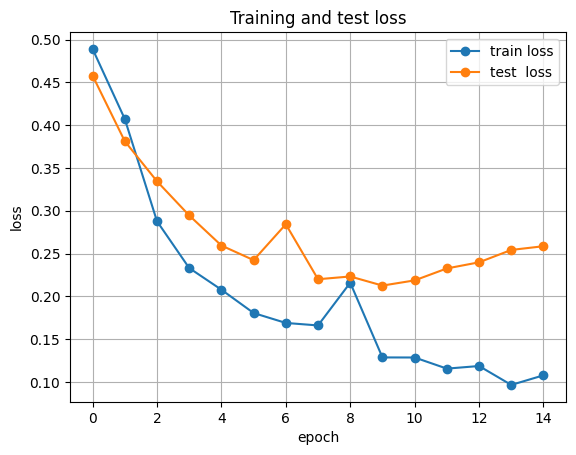

In [10]:
# Train
epochs = 15
history = []
for ep in range(epochs):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    te_loss, te_acc = run_epoch(test_loader,  train=False)
    history.append((tr_loss, tr_acc, te_loss, te_acc))
    if (ep + 1) % 5 == 0:
        print(f"epoch {ep+1:02d}  train_loss={tr_loss:.4f}  train_acc={tr_acc:.3f}  test_acc={te_acc:.3f}")

# Plot training curve
plt.figure()
plt.plot([h[0] for h in history], label="train loss", marker="o")
plt.plot([h[2] for h in history], label="test  loss", marker="o")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and test loss")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# Final evaluation
model.eval()
probs, y_true, y_pred = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits, _, _ = model(xb.to(device))
        p = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        probs.extend(p.tolist())
        y_true.extend(yb.numpy().tolist())
        y_pred.extend(logits.argmax(dim=1).cpu().numpy().tolist())

acc = accuracy_score(y_true, y_pred)
try:
    auc = roc_auc_score(y_true, probs)
except Exception:
    auc = float("nan")

print(f"Test accuracy: {acc:.3f}")
print(f"Test ROC AUC:  {auc:.3f}")
print(classification_report(y_true, y_pred, digits=3))

Test accuracy: 0.939
Test ROC AUC:  0.957
              precision    recall  f1-score   support

           0      0.882     0.750     0.811        20
           1      0.949     0.979     0.964        95

    accuracy                          0.939       115
   macro avg      0.916     0.864     0.887       115
weighted avg      0.937     0.939     0.937       115



Below we will plot the results:

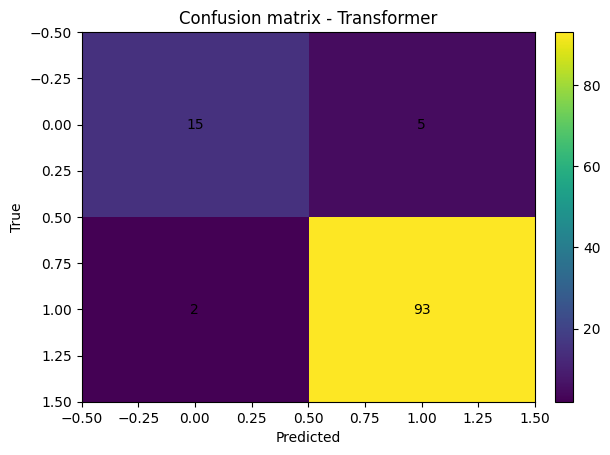

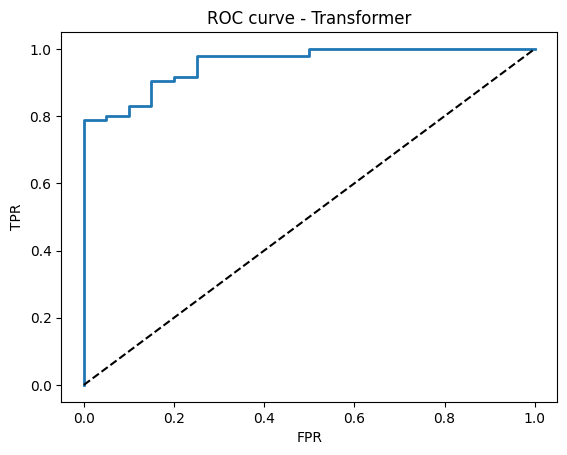

In [12]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, aspect="auto")
plt.title("Confusion matrix - Transformer")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

# ROC curve
try:
    fpr, tpr, thr = roc_curve(y_true, probs)
    plt.figure()
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curve - Transformer")
    plt.show()
except Exception as e:
    print("ROC not available:", e)

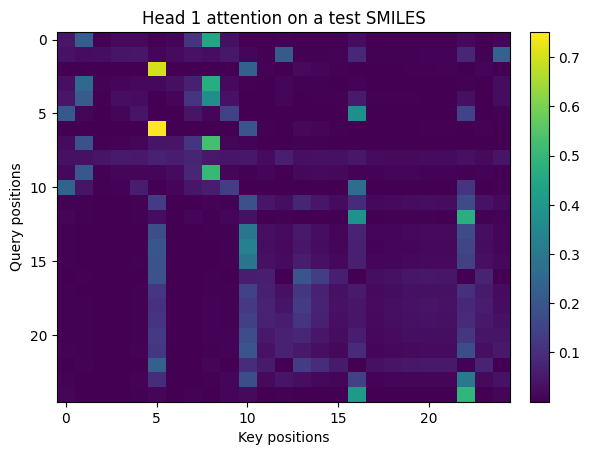

Tokens: ['O', '=', 'C', '(', 'O', ')', 'C', '(', '=', 'O', ')', 'c', '1', 'c', 'c', 'c', '2', 'c', 'c', 'c', 'c', 'c', '2', 'c', '1']


In [13]:
# Attention peek
def show_img(M, title=""):
    plt.figure()
    plt.imshow(M, aspect="auto")
    plt.title(title)
    plt.xlabel("Key positions")
    plt.ylabel("Query positions")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

# one batch
xb, yb = next(iter(test_loader))
with torch.no_grad():
    logits, attn, padmask = model(xb.to(device))

# attn shape handling
if isinstance(attn, torch.Tensor):
    if attn.dim() == 4:      # (B, heads, T, S)
        head0 = attn[0, 0].cpu().numpy()
    elif attn.dim() == 3:    # (heads, T, S)
        head0 = attn[0].cpu().numpy()
    else:
        head0 = attn.mean(0).cpu().numpy()
else:
    # unknown object, skip
    head0 = None

if head0 is not None:
    seq_ids = xb[0].numpy()
    tok_str = [itos[i] for i in seq_ids if i != PAD]
    T = len(tok_str)
    show_img(head0[:T, :T], title="Head 1 attention on a test SMILES")
    print("Tokens:", tok_str[:40])
else:
    print("Could not parse attention weights.")

---
## 6. Glossary

```{glossary}
Token 
    a basic symbol in a sequence. We use characters from SMILES.

Embedding
    a learned vector for each token.

Positional encoding
    a vector added to embeddings so the model knows token order.

Query, Key, Value (Q, K, V)
    linear projections of hidden states used in attention.


Attention weights
    softmax scores that say how much each position attends to others.


Head
    one set of Q, K, V projections inside multi-head attention.

Residual connection
    add input of a block to its output for stable optimization.

LayerNorm
    normalization per token over channels.

Cross entropy 
    a loss for classification.
```